# Exploratory Data Analysis

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# file retrieval
df = pd.read_csv('../data/unlabelled_data.csv')

## Data visualisation

In [3]:
# learn about my dataset
print(df.describe())

       rating_person  published_ago  response_from_owner_ago  \
count    3438.000000    3438.000000               644.000000   
mean        4.363874     247.489529               163.363354   
std         1.226916     494.829043               329.177232   
min         1.000000       0.000000                 0.000000   
25%         4.000000      10.000000                 8.000000   
50%         5.000000      47.000000                43.000000   
75%         5.000000     205.000000               158.000000   
max         5.000000    3715.000000              3049.000000   

       total_number_of_reviews_by_reviewer  \
count                          3438.000000   
mean                             62.714951   
std                             176.329915   
min                               0.000000   
25%                               3.000000   
50%                              11.000000   
75%                              41.000000   
max                            3058.000000   

       t

Numeric data: `rating_person`, `published_ago`, `response_from_owner_ago`, `total_number_of_reviews_by_reviewer`, `total_number_of_photos_by_reviewer`, `is_local_guide`, `is_spending_on_ads`, `reviews`, `rating_place`, `can_claim`

In [4]:
print(df.head())

                      place_id  \
0  ChIJU_Rb8VIZ2jER1wWC4e0_hXw   
1  ChIJU_Rb8VIZ2jER1wWC4e0_hXw   
2  ChIJU_Rb8VIZ2jER1wWC4e0_hXw   
3  ChIJU_Rb8VIZ2jER1wWC4e0_hXw   
4  ChIJU_Rb8VIZ2jER1wWC4e0_hXw   

                                           review_id            name_person  \
0  Ci9DQUlRQUNvZENodHljRjlvT25aUFRrcERUbEpVVVV3M0...                TIFFANY   
1  Ci9DQUlRQUNvZENodHljRjlvT2sxeFRYTTFVRVpwV0VsbF...             Joyin Chio   
2  Ci9DQUlRQUNvZENodHljRjlvT2tOSFZXOHhZVVJJTlhkdl...         Cheok Sao Hoon   
3  Ci9DQUlRQUNvZENodHljRjlvT25SM01rWjZWeTE1ZFRaUV...  Melissa LovesIceCream   
4  Ci9DQUlRQUNvZENodHljRjlvT2tSVmNFaDFMVXhHY201VW...           Lawrence Neo   

             reviewer_id  rating_person  \
0  102894114421490527374              5   
1  101329843800187896226              5   
2  107241069821421169260              5   
3  111353505751212189241              5   
4  102591407792887898032              5   

                                         review_text  publish

For numeric boolean data, need to convert NaN to 0 instead.
- is_local_guide
- is_spending_on_ads
- can_claim

In [5]:
# convert NaN to 0 for is_local_guide, is_spending_on_ads, can_claim
df['is_local_guide'] = df['is_local_guide'].fillna(0)
df['is_spending_on_ads'] = df['is_spending_on_ads'].fillna(0)
df['can_claim'] = df['can_claim'].fillna(0)

print(df.describe())

       rating_person  published_ago  response_from_owner_ago  \
count    3438.000000    3438.000000               644.000000   
mean        4.363874     247.489529               163.363354   
std         1.226916     494.829043               329.177232   
min         1.000000       0.000000                 0.000000   
25%         4.000000      10.000000                 8.000000   
50%         5.000000      47.000000                43.000000   
75%         5.000000     205.000000               158.000000   
max         5.000000    3715.000000              3049.000000   

       total_number_of_reviews_by_reviewer  \
count                          3438.000000   
mean                             62.714951   
std                             176.329915   
min                               0.000000   
25%                               3.000000   
50%                              11.000000   
75%                              41.000000   
max                            3058.000000   

       t

### Reviewer information

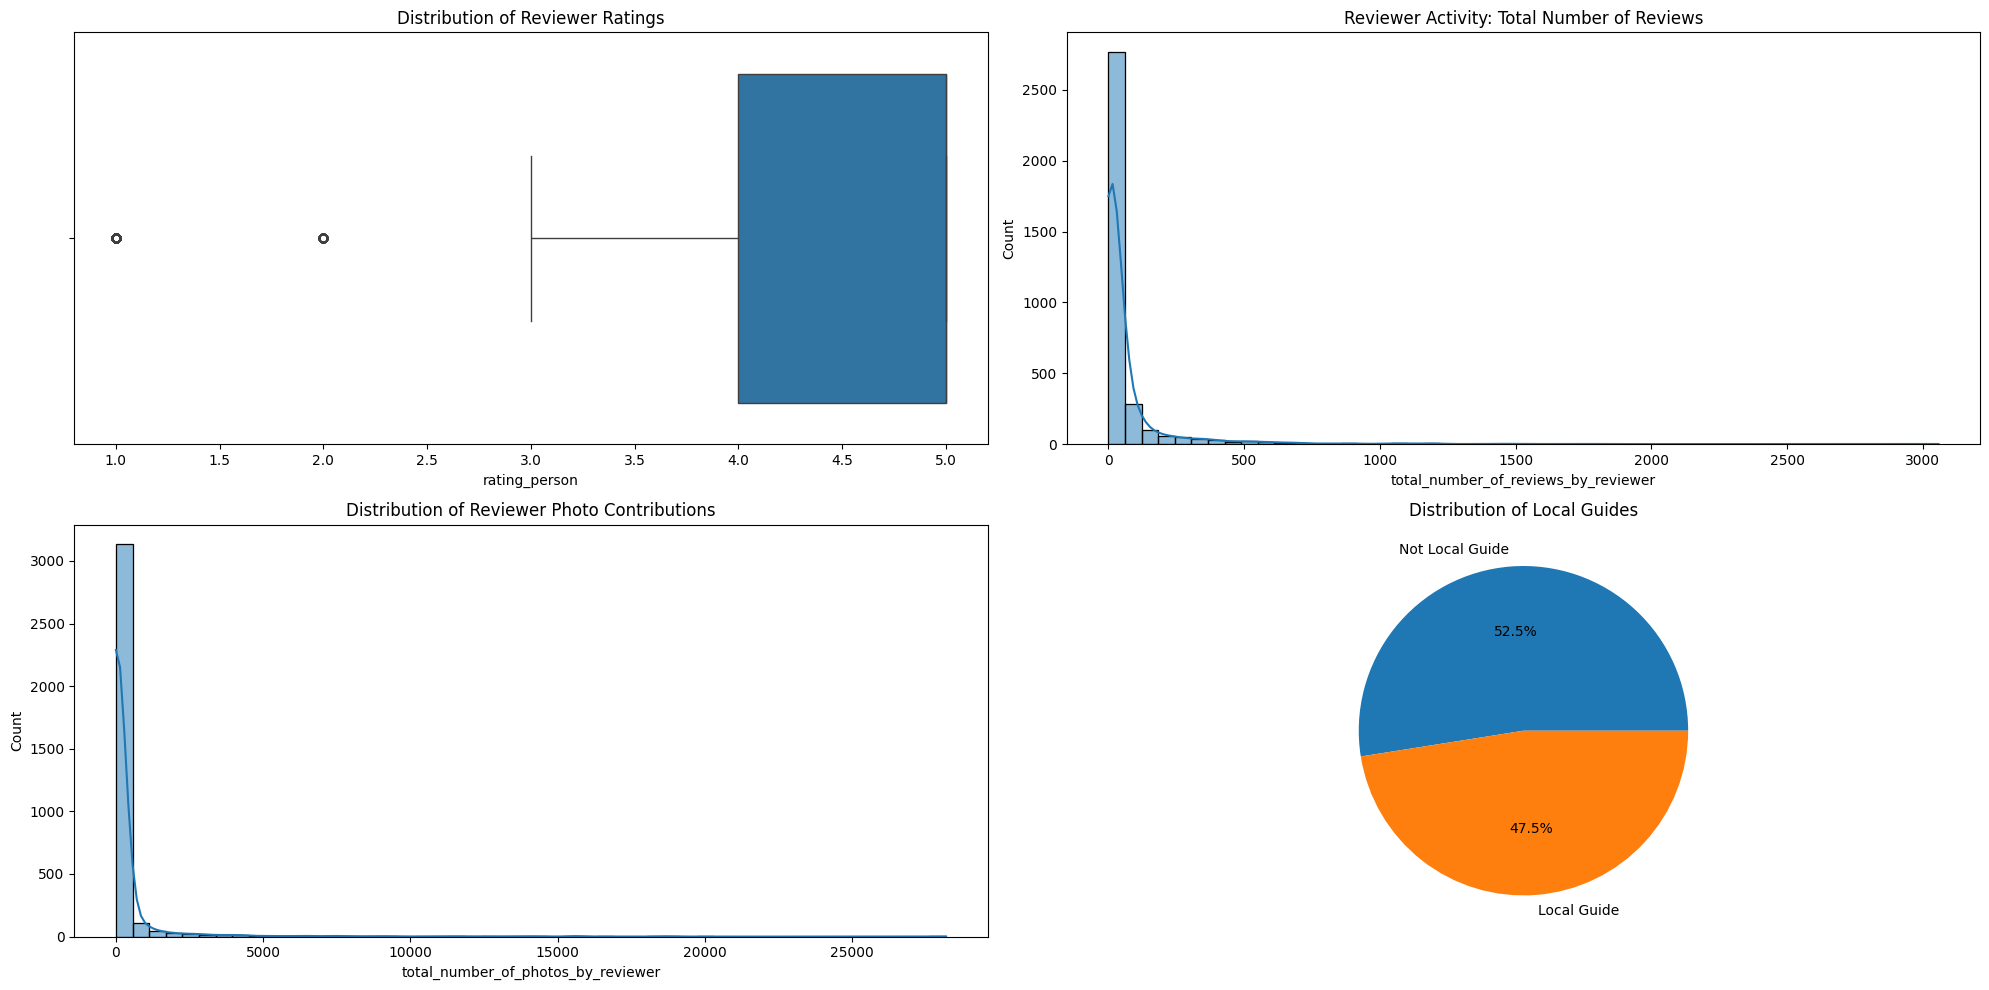

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# boxplot of reviewer ratings
sns.boxplot(x=df['rating_person'], ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Reviewer Ratings')

# Pie chart of is_local_guide
is_local_guide_counts = df['is_local_guide'].value_counts()
axs[1, 1].pie(is_local_guide_counts, labels=['Not Local Guide', 'Local Guide'], autopct='%1.1f%%')
axs[1, 1].set_title('Distribution of Local Guides')

# histogram of total_number_of_reviews_by_reviewer
sns.histplot(df['total_number_of_reviews_by_reviewer'], bins=50, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Reviewer Activity: Total Number of Reviews')

# histogram of total_number_of_photos_by_reviewer
sns.histplot(df['total_number_of_photos_by_reviewer'], bins=50, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Reviewer Photo Contributions')

fig.tight_layout()
plt.show()

### Place information

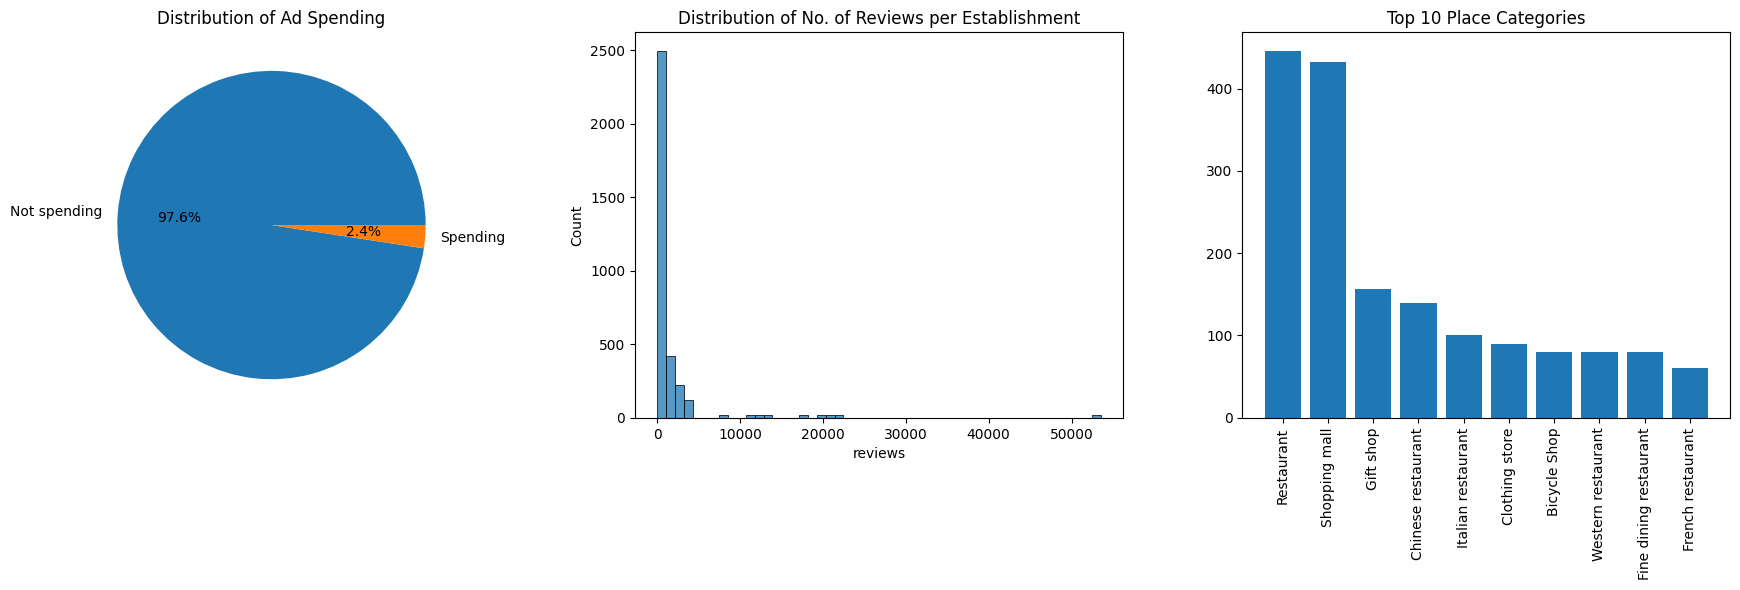

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# pie chart of is_spending_on_ads
is_spending_on_ads_counts = df['is_spending_on_ads'].value_counts()
axs[0].pie(is_spending_on_ads_counts, labels=['Not spending', 'Spending'],
           autopct='%1.1f%%')
axs[0].set_title('Distribution of Ad Spending')

# Histogram of reviews
sns.histplot(df['reviews'], bins=50, ax=axs[1])
axs[1].set_title('Distribution of No. of Reviews per Establishment')

# Bar chart of main_category
main_category_counts = df['main_category'].value_counts().head(10)
axs[2].bar(main_category_counts.index, main_category_counts.values)
axs[2].set_title('Top 10 Place Categories')
axs[2].tick_params(axis='x', rotation=90)

fig.tight_layout()

plt.show()

### Reviewer-Place Interaction

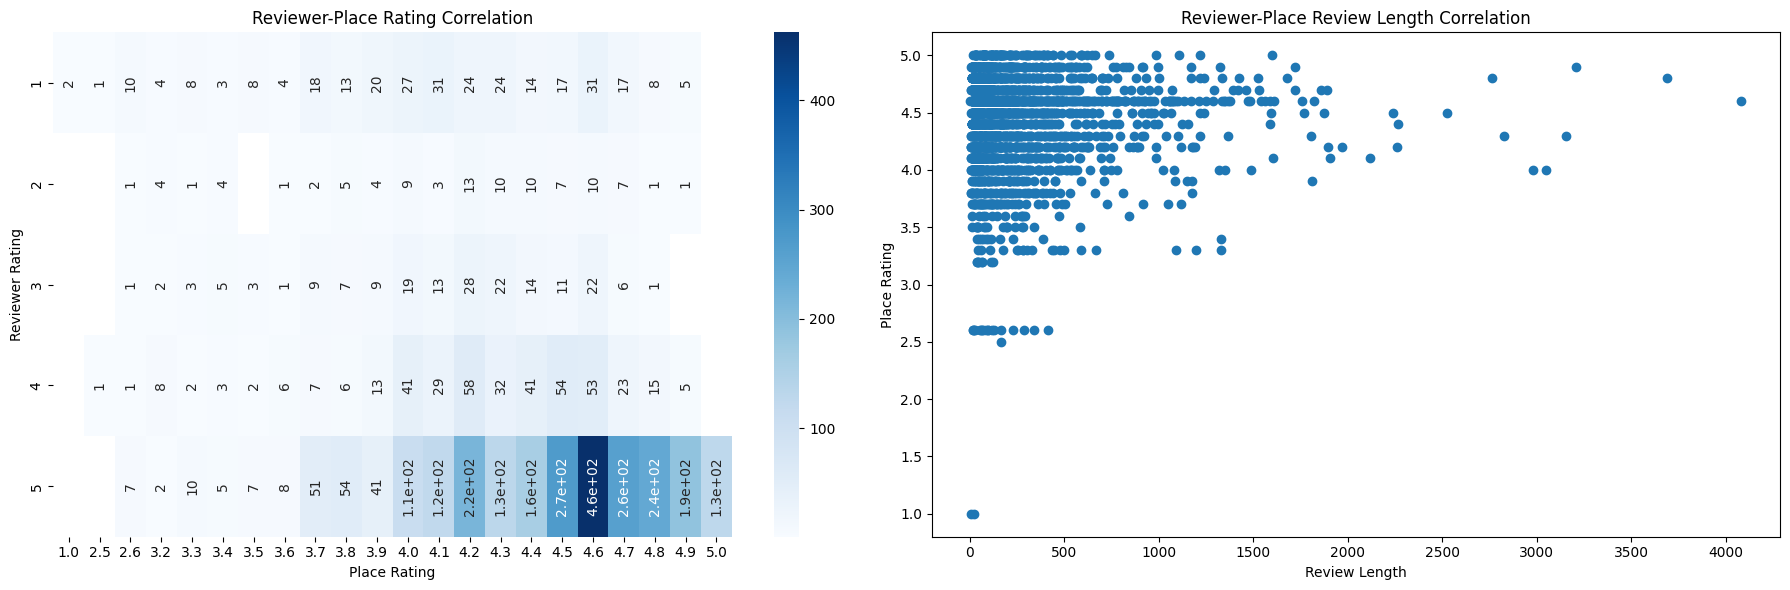

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap of rating_person vs. rating_place
rating_person_counts = df.groupby(['rating_person', 'rating_place']).size().unstack()
sns.heatmap(rating_person_counts, annot=True, annot_kws={'rotation': 'vertical'}, cmap='Blues', ax=axs[0])
axs[0].set_title('Reviewer-Place Rating Correlation')
axs[0].set_xlabel('Place Rating')
axs[0].set_ylabel('Reviewer Rating')

# Scatter plot of review text length vs. rating_place

axs[1].scatter(df['review_text'].str.len(), df['rating_place'])
axs[1].set_title('Reviewer-Place Review Length Correlation')
axs[1].set_xlabel('Review Length')
axs[1].set_ylabel('Place Rating')

fig.tight_layout()

plt.show()

### Time-based analysis

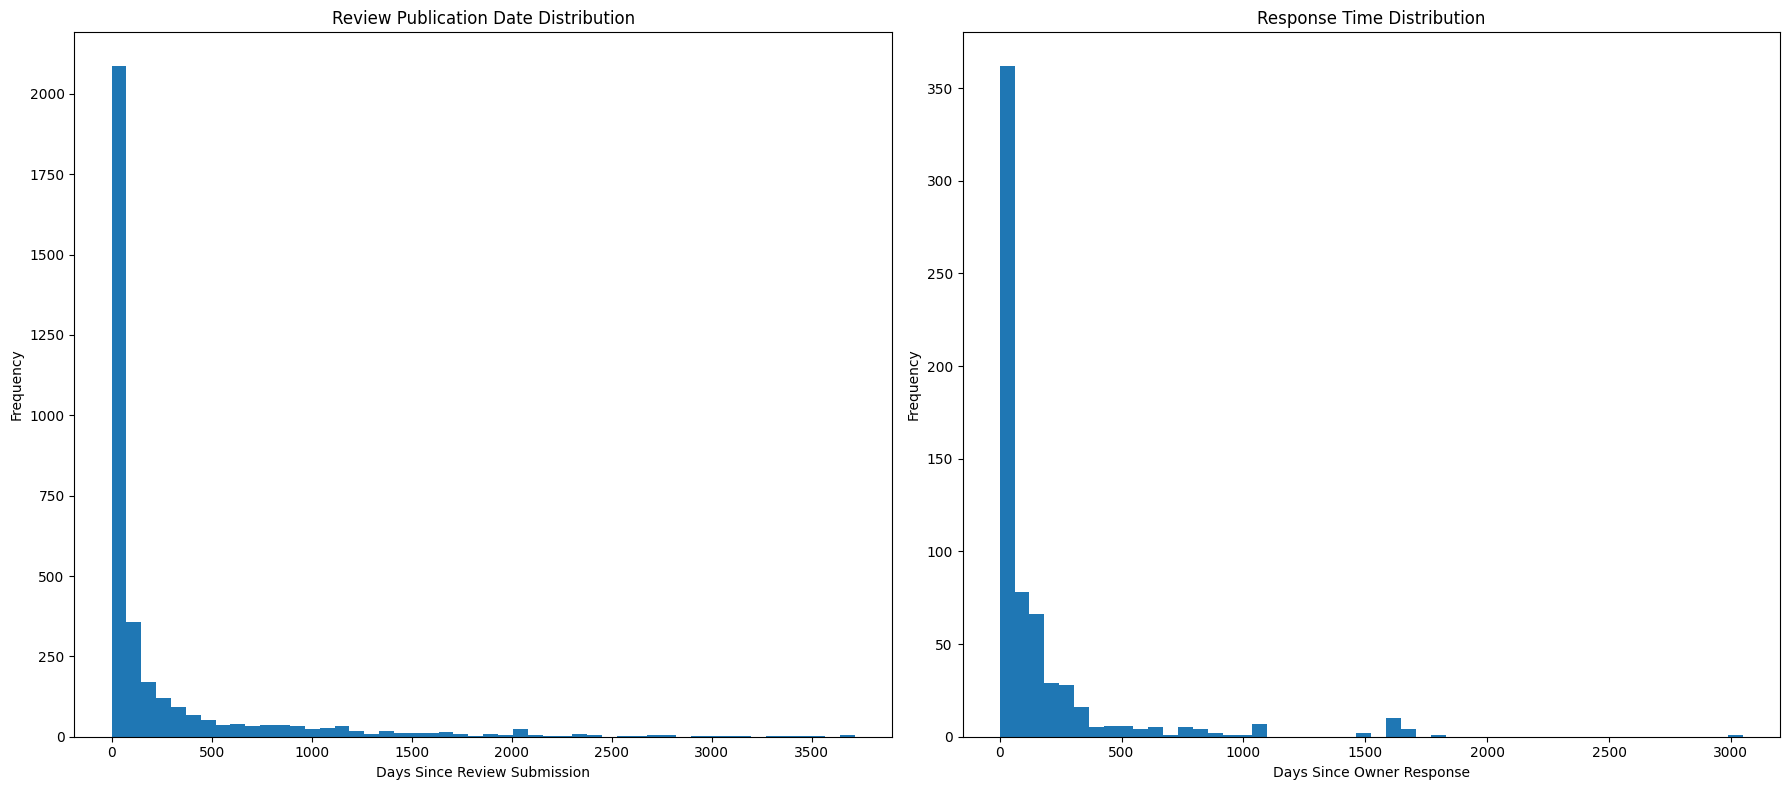

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Histogram of published_at
axs[0].hist(df['published_ago'], bins=50)
axs[0].set_title('Review Publication Date Distribution')
axs[0].set_xlabel('Days Since Review Submission')
axs[0].set_ylabel('Frequency')

# Histogram of response_from_owner_ago
axs[1].hist(df['response_from_owner_ago'], bins=50)
axs[1].set_title('Response Time Distribution')
axs[1].set_xlabel('Days Since Owner Response')
axs[1].set_ylabel('Frequency')

fig.tight_layout()

plt.show()

## Correlation matrix of numeric variables

Using non-boolean numeric variables

                                     rating_person  published_ago  \
rating_person                             1.000000      -0.085200   
published_ago                            -0.085200       1.000000   
total_number_of_reviews_by_reviewer      -0.003629       0.080244   
total_number_of_photos_by_reviewer       -0.004454       0.070303   
reviews                                   0.002006      -0.042812   
rating_place                              0.331195      -0.192559   

                                     total_number_of_reviews_by_reviewer  \
rating_person                                                  -0.003629   
published_ago                                                   0.080244   
total_number_of_reviews_by_reviewer                             1.000000   
total_number_of_photos_by_reviewer                              0.701788   
reviews                                                        -0.020235   
rating_place                                                

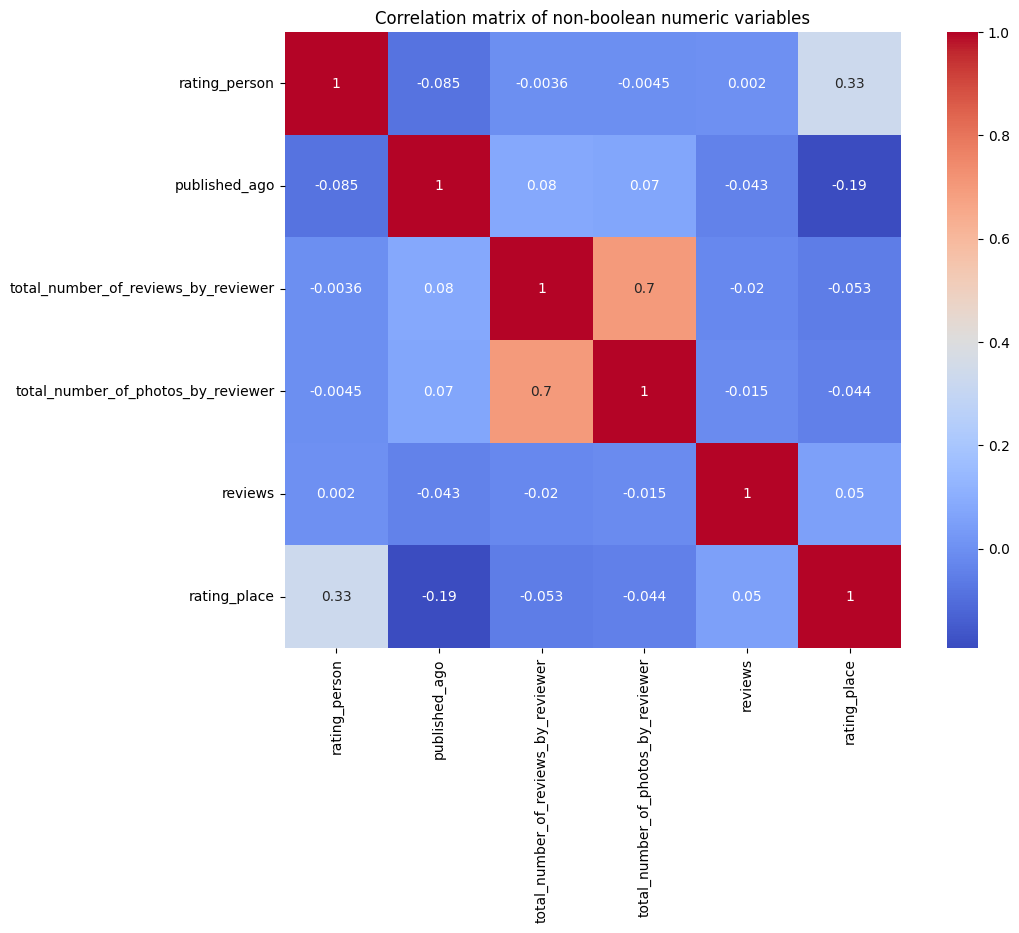

In [10]:
# excluded binary values
# excluded response_from_owner_date because it is not numerical for all its values (contains NaN)
corr_matrix_num = df[['rating_person', 'published_ago', 'total_number_of_reviews_by_reviewer', 
                      'total_number_of_photos_by_reviewer', 'reviews', 'rating_place']].corr()

print(corr_matrix_num)

# Heatmap of corr matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_num, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation matrix of non-boolean numeric variables')
plt.show()

# Feature Engineering for categorical variables

## Correlation matrix of categorical variables